In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class stationary_environment:
    def __init__(self, k):
        self.k = k
        self.mean = np.random.randint(-10, 20, k)
        self.cov = np.eye(k)
    
    def pull(self, a):
        return np.random.multivariate_normal(self.mean, self.cov)[a]
    
    def best_arm(self):
        return np.argmax(self.mean)

In [3]:
class epsilon_greedy_agent:
    def __init__(self, epsilon, environment, step_size=-1):
        self.epsilon = epsilon
        self.environment = environment
        self.k = environment.k
        self.N = np.zeros(self.k)
        self.Q = np.zeros(self.k)
        # step_size: defaut value -1 denotes sample average, custom value specifies constant step size
        self.step_size = step_size
        
    def get_reward(self, action):
        return self.environment.pull(action)
    
    def explore_and_exploit(self, steps=1000):
        avg_rewards = np.zeros(steps)
        optimal_actions_percentages = np.zeros(steps)
        total_reward = 0
        optimal_actions = 0
        for i in range(1, steps+1):
            rand = np.random.rand()
            if rand > self.epsilon:
                max_actions = np.argwhere(self.Q == np.amax(self.Q))
                action = max_actions[np.random.randint(0, len(max_actions))][0]
            else:
                action = np.random.randint(0, self.k)
            reward = self.get_reward(action)
            self.N[action] += 1
            if self.step_size == -1:
                self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])
            else:
                self.Q[action] += self.step_size * (reward - self.Q[action])
            total_reward += reward
            avg_rewards[i-1] = total_reward / i
            # if action is optimal action, increment the optimal action counter
            if self.environment.mean[action] == np.amax(self.environment.mean):
                optimal_actions += 1
            optimal_actions_percentages[i-1] = optimal_actions / i
        return avg_rewards, optimal_actions_percentages

In [4]:
class UCB:
    def __init__(self, c, environment):
        self.c = c
        self.environment = environment
        self.k = environment.k
        self.N = np.zeros(self.k)
        self.Q = np.zeros(self.k)
        
    def get_reward(self, action):
        return self.environment.pull(action)
    
    def explore_and_exploit(self, steps=1000):
        avg_rewards = np.zeros(steps)
        optimal_actions_percentages = np.zeros(steps)
        total_reward = 0
        optimal_actions = 0
        for i in range(1, steps+1):
            ucb_estimates = self.Q + self.c * np.sqrt(np.log(i) / (self.N + 1e-16))
            max_actions = np.argwhere(ucb_estimates == np.amax(ucb_estimates))
            action = max_actions[np.random.randint(0, len(max_actions))][0]
            reward = self.get_reward(action)
            self.N[action] += 1
            self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])
            total_reward += reward
            avg_rewards[i-1] = total_reward / i
            if self.environment.mean[action] == np.amax(self.environment.mean):
                optimal_actions += 1
            optimal_actions_percentages[i-1] = optimal_actions / i
        return avg_rewards, optimal_actions_percentages

In [5]:
env = stationary_environment(10)

epochs=200
steps=1000
avg1 = np.zeros(steps)
optimal1 = np.zeros(steps)
avg2 = np.zeros(steps)
optimal2 = np.zeros(steps)
avg3 = np.zeros(steps)
optimal3 = np.zeros(steps)
for i in range(epochs):
    tmp1, tmp2 = epsilon_greedy_agent(0.1, env).explore_and_exploit(steps)
    avg1 += tmp1
    optimal1 += tmp2
    
    tmp1, tmp2 = epsilon_greedy_agent(0.01, env).explore_and_exploit(steps)
    avg2 += tmp1
    optimal2 += tmp2
    
    tmp1, tmp2 = UCB(2, env).explore_and_exploit(steps)
    avg3 += tmp1
    optimal3 += tmp2
    
avg1 /= epochs
optimal1 /= epochs
avg2 /= epochs
optimal2 /= epochs
avg3 /= epochs
optimal3 /= epochs

## comparison of $\epsilon$-greedy $\epsilon = 0.1$, $\epsilon = 0.01$ and UCB $c = 2$ in a stationary environment

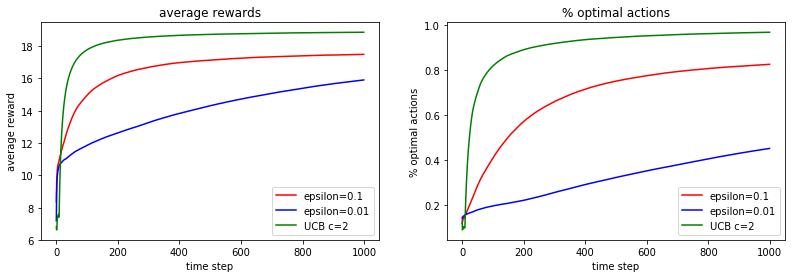

In [6]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(121)
ax.plot(avg1, "r")
ax.plot(avg2, "b")
ax.plot(avg3, "g")
plt.legend(["epsilon=0.1", "epsilon=0.01", "UCB c=2"])
plt.ylabel("average reward")
plt.xlabel("time step")
plt.title("average rewards")

ax = fig.add_subplot(122)
ax.plot(optimal1, "r")
ax.plot(optimal2, "b")
ax.plot(optimal3, "g")
plt.legend(["epsilon=0.1", "epsilon=0.01", "UCB c=2"])
plt.ylabel("% optimal actions")
plt.xlabel("time step")
plt.title("% optimal actions")
plt.show()

In [7]:
class nonstationary_environment:
    def __init__(self, k):
        self.k = k
        self.mean = np.random.randint(-2, 10, k).astype("float")
        self.cov = np.eye(k)
    
    def pull(self, a):
        self.mean += np.random.multivariate_normal(np.zeros(self.k), np.eye(self.k)*3)
        return np.random.multivariate_normal(self.mean, self.cov)[a]
    
    def best_arm(self):
        return np.argmax(self.mean)

In [8]:
epochs=20
steps=100000
avg1 = np.zeros(steps)
optimal1 = np.zeros(steps)
avg2 = np.zeros(steps)
optimal2 = np.zeros(steps)

nonstationary_env = nonstationary_environment(10)

for i in range(epochs):
    tmp1, tmp2 = epsilon_greedy_agent(0.1, nonstationary_env).explore_and_exploit(steps)
    avg1 += tmp1
    optimal1 += tmp2
    
    tmp1, tmp2 = epsilon_greedy_agent(0.1, nonstationary_env, 0.2).explore_and_exploit(steps)
    avg2 += tmp1
    optimal2 += tmp2

avg1 /= epochs
optimal1 /= epochs
avg2 /= epochs
optimal2 /= epochs

## comparsion of $\epsilon$-greedy with $\epsilon = 0.1$ with sample average step size and constant step size in a nonstationary environment

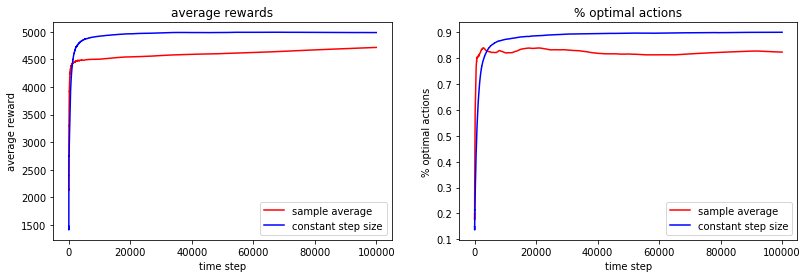

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(121)
ax.plot(avg1, "r")
ax.plot(avg2, "b")
plt.legend(["sample average", "constant step size"])
plt.ylabel("average reward")
plt.xlabel("time step")
plt.title("average rewards")

ax = fig.add_subplot(122)
ax.plot(optimal1, "r")
ax.plot(optimal2, "b")
plt.legend(["sample average", "constant step size"])
plt.ylabel("% optimal actions")
plt.xlabel("time step")
plt.title("% optimal actions")
plt.show()